Model Iteration Part 2 - Exploring Better Models

I got super excited from the reading on improving the submission of our first model exploration. Random forests and, more precisely, featuring seem very cool methods that I want to implement to improve my model. I am initially going to import all the relevant libraries and load the corresponding csv file with the training data.

In [15]:
import pandas
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier


titanic = pandas.read_csv("train.csv")

Once again, we will substitute all null/NaN values with the median of the column/parameter we are interested in playing with; this time, "Age" and "Embarked".

In [16]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())
titanic["Embarked"] = titanic["Embarked"].fillna("S")

# Replace all the occurences with the respctive value.
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1
titanic.loc[titanic["Embarked"] == 'S', "Embarked"] = 0
titanic.loc[titanic["Embarked"] == 'C', "Embarked"] = 1
titanic.loc[titanic["Embarked"] == 'Q', "Embarked"] = 2

In order to protect our model from overfitting, it is fundamental to break down the data into three folds, while at the same time, using the Linear Regression library to play with the train data.

In [17]:
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Algorith and folding declaration
alg = LinearRegression()
kf = sklearn.cross_validation.KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_predictors = (titanic[predictors].iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = titanic["Survived"].iloc[train]
    # Training the algorithm using the predictors and target.
    alg.fit(train_predictors, train_target)
    
    # We can now make predictions on the test fold
    test_predictions = alg.predict(titanic[predictors].iloc[test,:])
    predictions.append(test_predictions)


Combining the different folds back together, we get the following. In essence, it amalgamates the predictions in a binary fashion, by assigning any prediciton below and, including 0.5, to 0 and everything else to 1. Counting the number of 1's that appeared and dividing that over the total number of predictions yields an accuracy that is not super great but not bad either.

In [18]:
predictions = np.concatenate(predictions, axis=0)
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0

survivedCounter = 0.0

for i in range(0,len(predictions)):
     if (predictions[i] == titanic["Survived"][i]):
        survivedCounter += 1
        
accuracy = survivedCounter / len(predictions)
print "The accuracy of this model is just", accuracy


The accuracy of this model is just 0.783389450056


Instead of actually combining all the folds together and then looping through and counting the binary positive outcomes, one could apply Linear Regression to each different fold "bucket" and then average the predictions that each of the folds yielded, as seen below.

In [20]:
alg = sklearn.linear_model.LogisticRegression(random_state=1)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print "The new accuracy with linear regression on the three independent folds is averaged out to be", scores.mean()

The new accuracy with linear regression on the three independent folds is averaged out to be 0.787878787879


Honestly, I am not super interested in submitting this result to Kaggle and applying it to the test data, so how about we procceed to the development of a different model that will hopeully give us a better prediction.

As I previously mentioned, I really liked the way the DataQuest exploration combined random forest with featuring and I would like to apply such an algorithmic approach in my model. As seen below, I am applying a random forest and calculating the mean score out of the three folds we have. By tweaking the n_estimators and the min_samples_split parameters we observe an increase in the prediction. 

In [21]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

alg = RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=5, min_samples_leaf=1)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

print "The prediciton score has improved to", scores.mean()

The prediciton score has improved to 0.826038159371


I can now apply this model to our test data and make a submission to kaggle.

In [23]:
titanic_test = pandas.read_csv("test.csv")

# Handle NaNs
titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())
titanic_test["Embarked"] = titanic_test["Embarked"].fillna("S")
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic_test["Fare"].median())

titanic_test.loc[titanic_test["Sex"] == 'male', "Sex"] = 0
titanic_test.loc[titanic_test["Sex"] == 'female', "Sex"] = 1
titanic_test.loc[titanic_test["Embarked"] == 'S', "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == 'C', "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == 'Q', "Embarked"] = 2


alg = sklearn.linear_model.LogisticRegression(random_state=1)
alg.fit(titanic[predictors], titanic["Survived"])
predictions = alg.predict(titanic_test[predictors])

submission = pandas.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggleForest.csv", index=False)

Finally, I am going to explore a final version of this model search in order to improve my model. Something that I found really interesting was the ability to determine which fields in the data are the most important to train out of. Hence, let's write a script that indicates which are the preditors that we should be using the most in our new revised model.

Pclass:  24.5956714208
Sex:  68.8519942529
Age:  1.27768954597
SibSp:  0.534254502442
Parch:  1.82976042906
Fare:  14.2132351418
Embarked:  2.85130099045


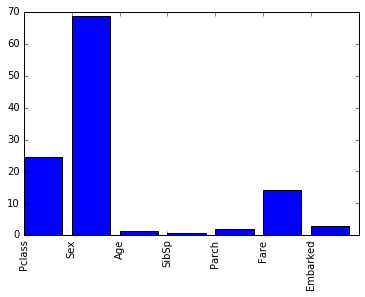

In [25]:
from sklearn.feature_selection import SelectKBest, f_classif
from matplotlib import pyplot as plt
%matplotlib inline

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

for i in range(0, len(predictors)):
    print predictors[i] + ': ', scores[i]

plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

Looking at the graph and value generated above, we can proceed as follows

In [27]:
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print "Accuracy", scores.mean()

Accuracy 0.818181818182


The result above is pretty much the same with the one we deduced earlier, therefore, we are going to develop a set of new features that we hope can aid us in the improving of our model.

In [35]:
# Generating a familysize column
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]

# The .apply method generates a new series
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

In [36]:
import re

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles and print how often each one occurs.
titles = titanic["Name"].apply(get_title)
print(pandas.value_counts(titles))

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

# Verify that we converted everything.
print(pandas.value_counts(titles))

# Add in the title column.
titanic["Title"] = titles


Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
Name: Name, dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64


In [31]:
import operator

# A dictionary mapping family name to id
family_id_mapping = {}

# A function to get the id given a row
def get_family_id(row):
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family id
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

# Get the family ids with the apply method
family_ids = titanic.apply(get_family_id, axis=1)

# There are a lot of family ids, so we'll compress all of the families under 3 members into one code.
family_ids[titanic["FamilySize"] < 3] = -1

# Print the count of each unique id.
print(pandas.value_counts(family_ids))

titanic["FamilyId"] = family_ids


-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


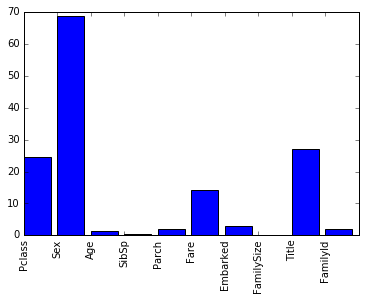

0.811447811448


In [38]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# Pick only the four best features.
predictors = ["Pclass", "Sex", "Fare", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

print(scores.mean())

Surprisingly enough, the "Title" parameter is significant in the exploration of an accurate surviral rate prediction, along with Sex and PClass while the parameter of FAmilySize and FamilyId doesn't seem to influence the result as much. Time to predict on the test dataset.

In [42]:
# First, we'll add titles to the test set.
titles = titanic_test["Name"].apply(get_title)
# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles
# Check the counts of each unique title.
print(pandas.value_counts(titanic_test["Title"]))

# Now, we add the family size column.
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

# Now we can add family ids.
# We'll use the same ids that we did earlier.
print(family_id_mapping)

family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1
titanic_test["FamilyId"] = family_ids

titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))

1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
Name: Title, dtype: int64
{"O'Sullivan0": 426, 'Mangan0': 620, 'Lindqvist1': 543, 'Denkoff0': 297, 'Rouse0': 413, 'Berglund0': 207, 'Meo0': 142, 'Arnold-Franchi1': 49, 'Chronopoulos1': 71, 'Skoog5': 63, 'Widener2': 329, 'Pengelly0': 217, 'Goncalves0': 400, 'Myhrman0': 626, 'Beane1': 456, 'Moss0': 104, 'Carlsson0': 610, 'Nicholls2': 136, 'Jussila1': 110, 'Jussila0': 483, 'Long0': 632, 'Wheadon0': 33, 'Connolly0': 261, 'Hansen2': 680, 'Stephenson1': 493, 'Davies0': 336, 'Silven2': 359, 'Vanden Steen0': 311, 'Astor1': 571, 'Patchett0': 480, 'Johanson0': 184, 'Coleridge0': 220, 'Christmann0': 87, 'Carter3': 340, 'Compton2': 665, 'Carter1': 226, 'Turkula0': 414, 'Hassab0': 558, 'Saad0': 566, 'Mellors0': 208, 'Mamee0': 36, 'Madsen0': 119, 'Anderson0': 395, 'Kraeff0': 42, 'Robbins0': 468, 'Lundahl0': 522, 'Gilinski0': 490, 'Porter0': 107, 'Sdycoff0': 352, 'Green0': 204, 'Bishop1': 263, 'Sinkkonen0': 603, 'Otter0':

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4

predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1
predictions = predictions.astype(int)

submission = pandas.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggleFeatures.csv", index=False)

My Kaggle rating improved significantly to 0.79904 by classifying early on the features I want to focus on and applying gradient boosting and logistic regression on the titles that affect the result more.

I believe that there is definetely a lot of different things one can think about to improve the model even more. As I explored in the model_iteration_1 notebook, I created a binary parameter that specified whether or not a person was a child or not by defining a specific threshold that determined the age barrier. Including this idea into a future iteration of the model would definetely improve the prediction. Ideas for future exploration could involve the use of more parameters, such as rankings based on particular and more specific age groups. Finally, I would love to devote more time in making more appropriate helper functions, as well as understand in more detail how the selectKBest method works, as right now it seems to be treated like a black box.